In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import plotly_express as px
import time
import queue
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from shapely.geometry import Point, LineString

In [2]:
def geocode_with_retry(address, geolocator, max_retries=20, timeout=10):
    retries = 0
    while retries < max_retries:
        try:
            location = geolocator.geocode(address, timeout=timeout)
            return location
        except Exception:
            retries += 1
            print(f"Geocoder timed out, retrying... ({retries}/{max_retries})")
            time.sleep(1)
    return None

In [3]:
class Node ():
    def __init__(self, state, value, operators=[], operator=None, parent=None, objective=None):
        self.state = state
        self.value = value
        self.children = []
        self.parent = parent
        self.operator = operator
        self.objective = objective
        self.level = 0
        self.operators = operators

    def add_child(self, value, state, operator):
        node = type(self)(value=value, state=state, operator=operator, parent=self, operators=self.operators, objective=self.objective)
        self.add_node_child(node)
        return node

    def add_node_child(self, node):
        node.level = node.parent.level + 1
        self.children.append(node)
        return node

  #Devuelve todos los estados según los operadores aplicados
    def get_childrens(self):
        children = []
        for i in range(len(self.operators)):
            state = self.get_state(i)
            if (self.is_ancestor(state)):
                children.append(None)
            else:
                children.append(state)
        
        return children
        # return [
        #     self.get_state(i)
        #       if not self.is_ancestor(self.get_state(i))
        #         else None 
        #         for i, op in enumerate(self.operators)
        #     ]


    def get_state(self, index):
        pass

    def is_ancestor(self, state):
        n = self
        while n is not None and n.state != state:
            n = n.parent
        return n is not None

    def path_to_objective(self):
        n = self
        result = []
        while n is not None:
            result.append(n.state)
            n = n.parent
        return result

    def heuristic(self):
        return 0

    def cost(self):
        return 1

    def f(self):
        return self.cost() + self.heuristic()

    def __eq__(self, other):
        return self.state == other.state

    def __lt__(self, other):
        return self.f() < other.f()


In [4]:
#%%writefile utils/Tree_3.py
class Tree():
  def __init__(self, root, operators):
    self.root = root
    self.operators = operators

  def print_path(self, n):
    path = n.path_to_objective()
    for i in path:
        if i.operator is not None:
            print(f'operador:  {self.operators[node.operator]} \t estado: {node.state}')
        else:
            print(f' {node.state}')
    return path
    # stack = n.path_to_objective()
    # path = stack.copy()
    # while len(stack) != 0:
    #     node = stack.pop()
    #     if node.operator is not None:
    #         print(f'operador:  {self.operators[node.operator]} \t estado: {node.state}')
    #     else:
    #         print(f' {node.state}')
    # return path

  def reinit_root(self):
    self.root.operator = None
    self.root.parent = None
    self.root.objective = None
    self.root.children = []
    self.root.level = 0

  ## Primero a lo ancho
  def breadth_first(self, endState):
    self.reinit_root()
    self.root.objective = endState
    pq = queue.Queue()
    pq.put(self.root)
    while not pq.empty():
      node = pq.get()
      if node.state == endState:
        return node
      children = node.get_childrens()
      for i, child in enumerate(children):
        if child is not None:
          newChild = node.add_child(value=node.value + '-' + str(i), state=child, operator=i)
          pq.put(newChild)
          if endState == child:
            return newChild

  ## Primero en profundidad
  def depht_first(self, endState):
    self.reinit_root()
    self.root.objective = endState
    pq = []
    pq.append(self.root)
    while len(pq) > 0:
      node = pq.pop()
      if (node.parent is not None):
        node.parent.add_node_child(node)
      if node.state == endState:
        return node
      children = node.get_childrens()
      temp = []
      for i, child in enumerate(children):
        if child is not None:
          newChild = type(self.root)(value=str(node.value) + '-' + str(i), state=child, operator=i, parent=node, operators=node.operators)
          temp.append(newChild)
          if endState == child:
            node.add_node_child(newChild)
            return newChild
      #Adicionar los hijos en forma inversa para que salga primero el primero que se adicionó
      temp.reverse()
      for e in temp:
        pq.append(e)

  ## Costo uniforme
  def uniform_cost(self, endState):
    self.reinit_root()
    self.root.objective = endState
    pq = queue.PriorityQueue()
    pq.put((self.root.cost(), self.root))
    while not pq.empty():
      node = pq.get()[1]
      if node.state == endState:
        return node
      children = node.get_childrens()
      for i, child in enumerate(children):
        if child is not None:
          newChild = node.add_child(value=str(node.value) + '-' + str(i), state=child, operator=i)
          pq.put((newChild.cost(), newChild))
          if endState == child:
            return newChild

  ## Primero el mejor
  def best_first(self, endState):
    self.reinit_root()
    self.root.objective = endState
    pq = queue.PriorityQueue()
    pq.put((self.root.heuristic(), self.root))
    while not pq.empty():
      node = pq.get()[1]
      if node.state == endState:
        return node
      children = node.get_childrens()
      for i, child in enumerate(children):
        if child is not None:
          newChild = node.add_child(value=str(node.value) + '-' + str(i), state=child, operator=i)
          pq.put((newChild.heuristic(), newChild))
          if endState == child:
            return newChild

  ## A*
  def astar(self, endState):
    self.reinit_root()
    self.root.objective = endState
    pq = queue.PriorityQueue()
    pq.put((self.root.f(), self.root))
    while not pq.empty():
      node = pq.get()[1]
      if node.state == endState:
        return node
      children = node.get_childrens()
      for i, child in enumerate(children):
        if child is not None:
          newChild = node.add_child(value=str(node.value) + '-' + str(i), state=child, operator=i)
          pq.put((newChild.f(), newChild))
          if endState == child:
            return newChild

  ## Método para dibujar el árbol
  def draw(self,path):
    graph = pydot.Dot(graph_type='graph')
    nodeGraph = pydot.Node(str(self.root.state) + "-" + str(0),
                          label=str(self.root.state), 
                          shape ="circle",
                          style="filled",
                          fillcolor="red")
    graph.add_node(nodeGraph)
    path.pop()
    return self.draw_tree_rec(self.root, nodeGraph, graph, 0, path.pop(), path)

  ## Método recursivo para dibujar el árbol
  def draw_tree_rec(self, r, rootGraph, graph, i, topPath, path):
    if r is not None:
      children = r.children
      for j,child in enumerate(children):
        i = i + 1
        color="white"
        if topPath.value == child.value:
          if len(path) > 0 : topPath = path.pop()
          color='red'
        c = pydot.Node(child.value, label=str(child.state) + r"\n\n" + "f=" + str(child.f()),
                      shape ="circle",
                      style="filled",
                      fillcolor=color)
        graph.add_node(c)
        graph.add_edge(pydot.Edge(rootGraph, c,
                                  label=str(child.operator) + '(' + str(child.cost()) + ')'))
        graph = self.draw_tree_rec(child, c, graph, i, topPath, path)  # recursive call
      return graph
    else:
      return graph


In [5]:
class Map:
    def __init__(self, area: str, simplify: bool = False):
        self.area = area
        self._simplify = simplify
        self.nodes = pd.DataFrame([])
        self.edges = pd.DataFrame([])
        self.init_data()
    
    def init_data(self):
        self.G = ox.graph_from_place(self.area, network_type="drive", simplify=self._simplify)
        self.show = ox.plot_graph(self.G, figsize=(25, 25))
        # call add other info
        self.add_speeds()
        self.add_travel_times()
        self.add_elevations()
        self.add_nodes_edges()
    
    def add_nodes_edges(self):
        self.nodes, self.edges = ox.graph_to_gdfs(self.G)
    
    def add_elevations(self):
        self.G = ox.elevation.add_node_elevations_raster(self.G, "./utils/envigado.tif", band=1)
        self.G = ox.add_edge_grades(self.G, add_absolute=True)
    
    def add_speeds(self):
        hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
        self.G = ox.add_edge_speeds(self.G, hwy_speeds, fallback=40)
    
    def add_travel_times(self):
        """
        Add travel times (seconds) for edges based on edge length and speed.
        """
        self.G = ox.add_edge_travel_times(self.G)

    def get_adjacents(self, node_osmid):
        if node_osmid in self.edges.index.get_level_values('u'):
            adj = self.edges.xs(node_osmid, level="u")
            adj = adj.index.get_level_values("v").tolist()
            #adj = self.edges[self.edges['u'] == node_osmid].tolist()
            return adj
        else:
            return []
        # return [1, 2, 3, 4, 5, 10]
    
    def get_all_locations(self):
        # nodes.index.tolist() == nodes.index.get_level_values("osmid").tolist()
        return self.nodes.index.tolist()
    
    def get_edge_distance(self, u, v):
        key = (u, v, 0)
        if key in map.edges.index:
            return map.edges.loc[key]["length"]
        return 0
        
    def display_interactive_route(self, route, start_node, end_node):
        node_start = []
        node_end = []
        X_to = []
        Y_to = []
        X_from = []
        Y_from = []
        length = []
        travel_time = []

        for u, v in zip(route[:-1], route[1:]):
            node_start.append(u)
            node_end.append(v)
            length.append(round(self.G.edges[(u, v, 0)]["length"]))
            travel_time.append(round(self.G.edges[(u, v, 0)]["travel_time"]))
            X_from.append(self.G.nodes[u]["x"])
            Y_from.append(self.G.nodes[u]["y"])
            X_to.append(self.G.nodes[v]["x"])
            Y_to.append(self.G.nodes[v]["y"])
        df = pd.DataFrame(
            list(
                zip(
                    node_start,
                    node_end,
                    X_from,
                    Y_from,
                    X_to,
                    Y_to,
                    length,
                    travel_time,
                )
            ),
            columns=[
                "node_start",
                "node_end",
                "X_from",
                "Y_from",
                "X_to",
                "Y_to",
                "length",
                "travel_time",
            ],
        )
        df.reset_index(inplace=True)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X_from, df.Y_from))
        gdf["geometry_to"] = [Point(xy) for xy in zip(gdf.X_to, gdf.Y_to)]
        gdf["line"] = gdf.apply(
            lambda row: LineString([row["geometry_to"], row["geometry"]]), axis=1
        )
        line_gdf = gdf[
            ["node_start", "node_end", "length", "travel_time", "line"]
        ].set_geometry("line")
        start = df[df["node_start"] == start_node]
        end = df[df["node_end"] == end_node]
        fig = px.scatter_mapbox(
            df,
            lon="X_from",
            lat="Y_from",
            zoom=12,
            width=1000,
            height=600,
            animation_frame="index",
            mapbox_style="open-street-map",
        )
        fig.data[0].marker = dict(size=12, color="black")
        fig.add_trace(px.scatter_mapbox(start, lon="X_from", lat="Y_from").data[0])
        fig.data[1].marker = dict(size=15, color="red")
        fig.add_trace(px.scatter_mapbox(end, lon="X_from", lat="Y_from").data[0])
        fig.data[2].marker = dict(size=15, color="green")
        fig.add_trace(px.line_mapbox(df, lon="X_from", lat="Y_from").data[0])
        


In [6]:
import math
from geopy.distance import geodesic
isCar = True
class Location(Node):
    # static map
    map: Map = None

    def __init__(self, state, value, map: Map = None, **kwargs):
        if map is not None:
            Location.map = map
        super(Location, self).__init__(state=state, value=value, **kwargs)
        self.operators = self.get_operators()

    def get_operators(self):
        return self.map.get_adjacents(self.state)

    def get_state(self, index):
        if len(self.operators) > index:
            return self.operators[index]

    def cost(self):
        if self.parent is None:
            return 0
        return self.map.get_edge_distance(self.state, self.parent.state)

    def heuristic(self):
        # calculate distance from node to objective
        a = (self.map.G.nodes[self.state]['x'], self.map.G.nodes[self.state]['y'])
        b = (self.map.G.nodes[self.objective]['x'], self.map.G.nodes[self.objective]['y'])
        value = 0

        if (self.state, self.objective, 0) in self.map.G.edges:
            if isCar:
                # get grade_abs
                grade = self.map.G.edges[(self.state, self.objective, 0)]['grade_abs']
                # get speed
                speed = self.map.G.edges[(self.state, self.objective, 0)]['speed_kph']
                # get v_max
                v_max_adj = speed * (1 - 0.3 * math.sin(grade))
                # get length
                length = self.map.G.edges[(self.state, self.objective, 0)]['length']
                # get time
                value = length / v_max_adj
            else:
                # Get highway
                # {"residential": 35, "secondary": 50, "tertiary": 60}
                grade = self.map.G.edges[(self.state, self.objective, 0)]['grade_abs']
                highway = self.map.G.edges[(self.state, self.objective, 0)]['highway']
                if highway == 'tertiary':
                    value = 10
                elif highway == 'secondary':
                    value = 20
                elif highway == 'residential':
                    value = 30
                else:
                    value = 0

                value = value + grade
        else:
            # Handle the case where the edge does not exist
            value = float('inf')  # or some other appropriate value

        heuristic_value = geodesic(a, b).meters + value
        return heuristic_value

In [7]:
class PathFinder(Tree):
    def __init__(self, start: str, end: str, map: Map, start_node=None, end_node=None):
        self.__locator = Nominatim(user_agent="ai-eia-2024-2-isis")

        self.map = map

        if start_node is None:
            self.start_coordinates = geocode_with_retry(start, self.__locator)
            self.start = (self.start_coordinates.latitude, self.start_coordinates.longitude)
            self.start_node = ox.distance.nearest_nodes(map.G, self.start[1], self.start[0])
        else:
            self.start_node = start_node
        
        if end_node is None:
            self.end_coordinates = geocode_with_retry(end, self.__locator)
            self.end = (self.end_coordinates.latitude, self.end_coordinates.longitude)
            self.end_node = ox.distance.nearest_nodes(map.G, self.end[1], self.end[0])
        else:
            self.end_node = end_node

        root = Location(self.start_node, "root", map=self.map, objective=self.end_node)
        all_operators = map.get_all_locations()

        super(PathFinder, self).__init__(root, all_operators)
    
    def depth_first_(self):
        node = self.depth_first(self.end_node)
        route = node.path_to_objective()
        # self.display(route)
        return route
    
    def uniform_cost_(self):
        node = self.uniform_cost(self.end_node)
        route = node.path_to_objective()
        # self.display(route)
        return route

    def breadth_first_(self):
        node = self.breadth_first(self.end_node)
        route = node.path_to_objective()
        return route
    
    def astar_(self):
        node = self.astar(self.end_node)
        route = node.path_to_objective()
        return route
        
    def display(self, route):
        self.map.display_interactive_route(route, self.start_node, self.end_node)

    

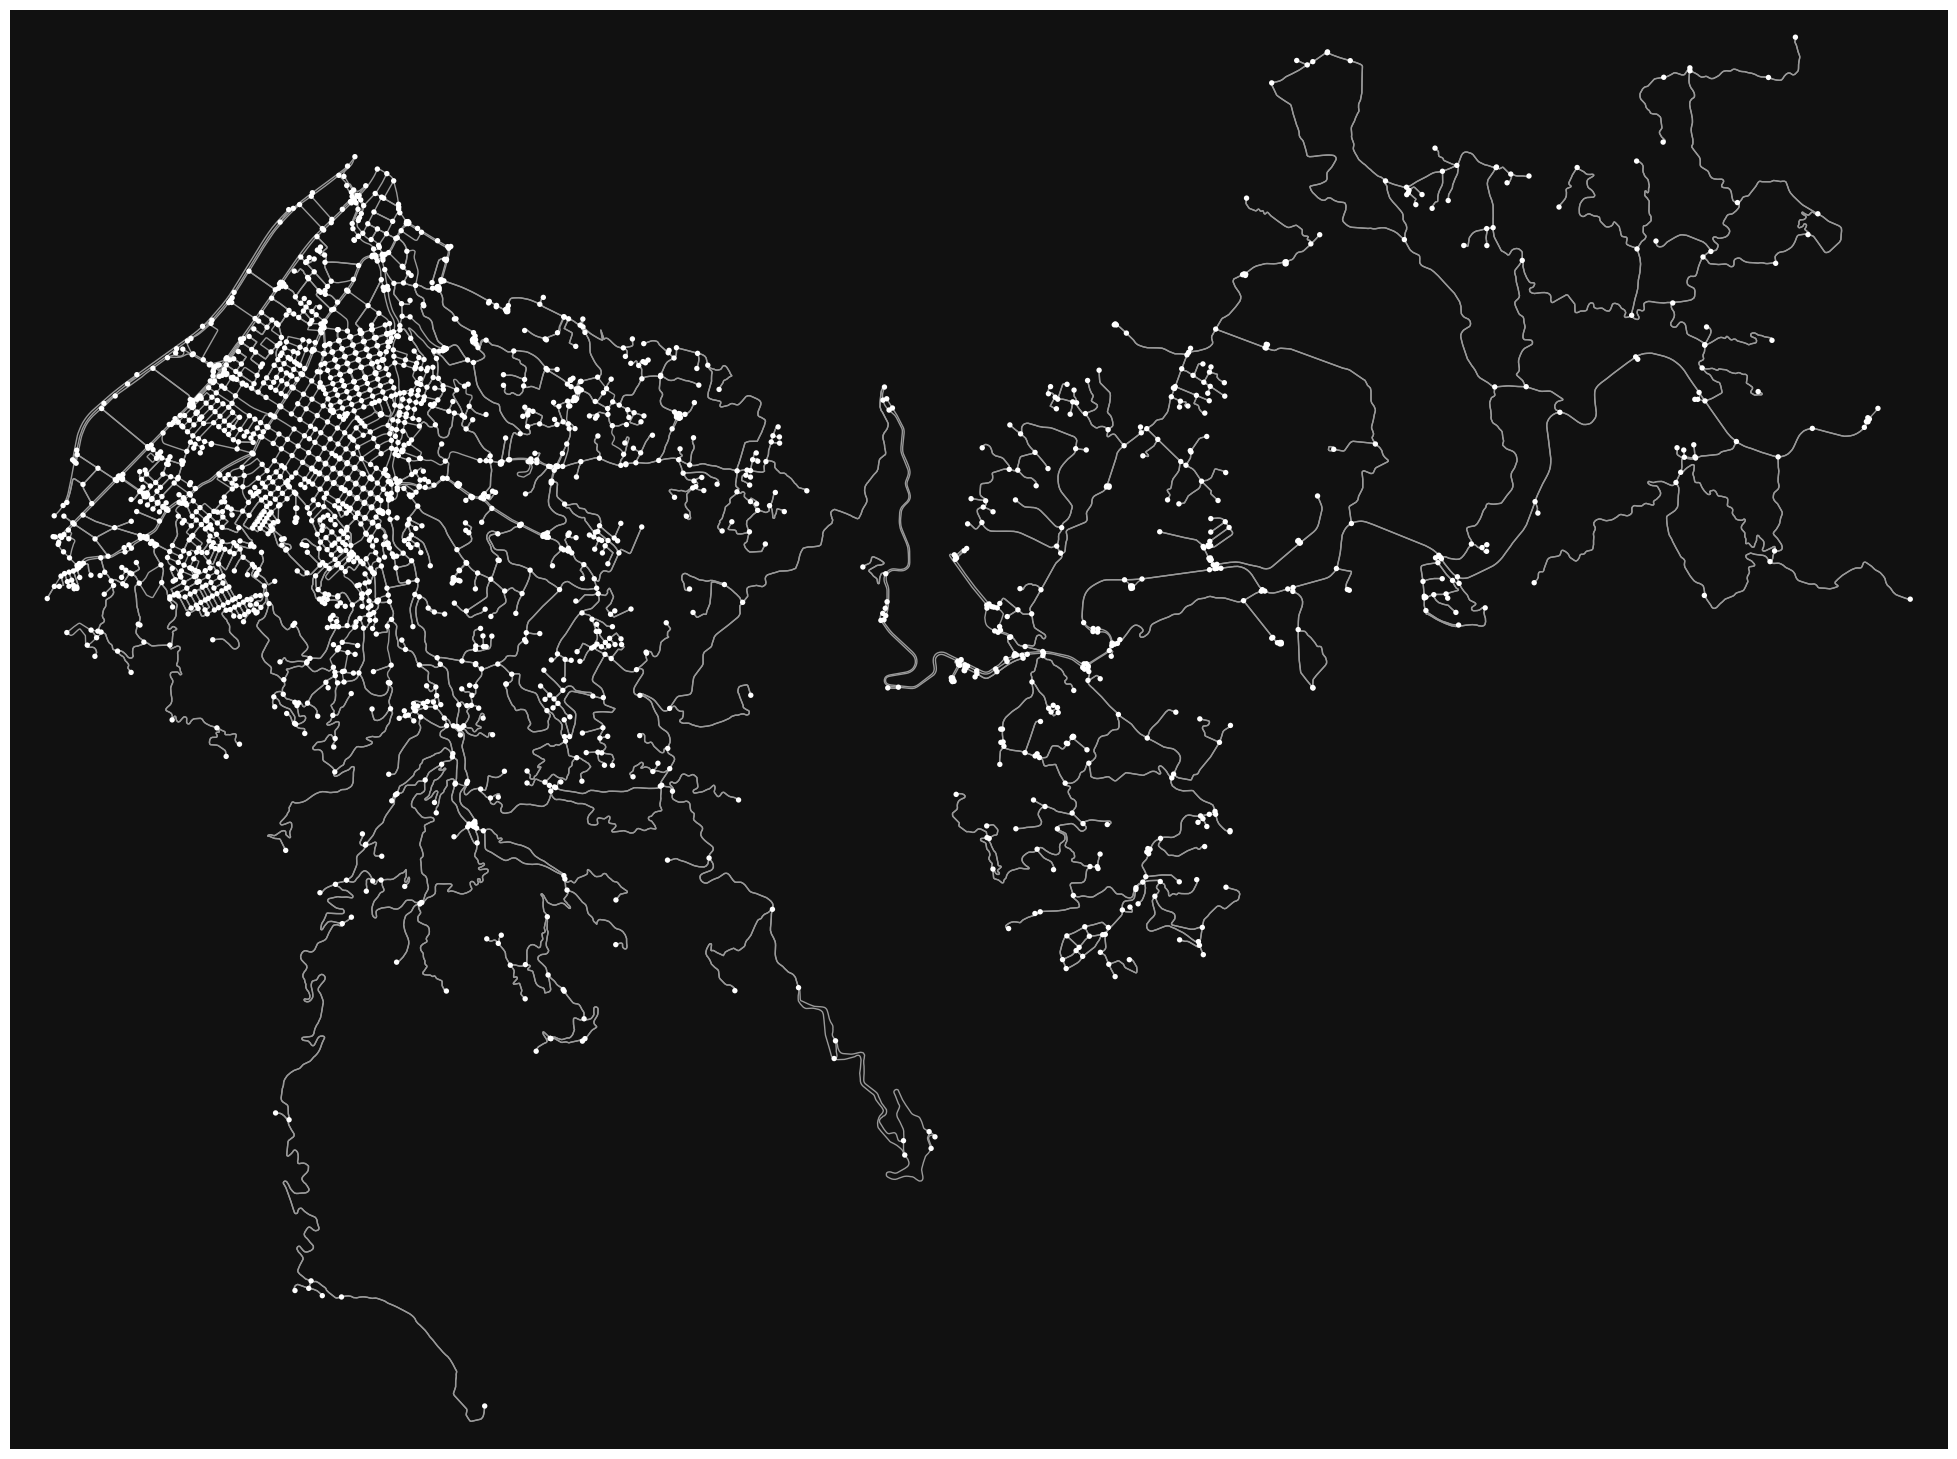

In [8]:
map = Map("Envigado, Antioquia, Colombia", simplify=True)

In [9]:
# print("NDOES")
# print(map.nodes.info())
# print("EDGES")
# print(map.edges.info())
map.edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 5039 entries, (309313457, 9388283663, 0) to (12050427898, 12050426244, 0)
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   osmid        5039 non-null   object  
 1   oneway       5039 non-null   bool    
 2   lanes        1422 non-null   object  
 3   name         3173 non-null   object  
 4   highway      5039 non-null   object  
 5   maxspeed     685 non-null    object  
 6   reversed     5039 non-null   object  
 7   length       5039 non-null   float64 
 8   geometry     5039 non-null   geometry
 9   speed_kph    5039 non-null   float64 
 10  travel_time  5039 non-null   float64 
 11  grade        5039 non-null   float64 
 12  grade_abs    5039 non-null   float64 
 13  bridge       64 non-null     object  
 14  width        220 non-null    object  
 15  junction     85 non-null     object  
 16  ref          68 non-null     object  
 17  access       

In [10]:
map.nodes.head()

,y,x,street_count,elevation,highway,geometry
osmid,,,,,,
309313457,6.159980,-75.524411,3,2553.0,NaN,POINT (-75.52441 6.15998)
309313461,6.159346,-75.529052,3,2538.0,NaN,POINT (-75.52905 6.15935)
309313472,6.154794,-75.531127,3,2490.0,NaN,POINT (-75.53113 6.15479)
309313473,6.154454,-75.531297,3,2489.0,NaN,POINT (-75.53130 6.15445)
322009433,6.185485,-75.582940,4,1517.0,traffic_signals,POINT (-75.58294 6.18548)


In [11]:
map.G.nodes[309313457]


{'y': 6.1599796, 'x': -75.524411, 'street_count': 3, 'elevation': 2553.0}

In [12]:
map.edges.head(10)

osmid  oneway lanes                 name  \
u         v          key                                                  
309313457 9388283663 0    1299081178    True     1  Variante Las Palmas   
          309313461  0    1299081179   False     2  Variante Las Palmas   
309313461 5001821095 0    1019190821   False     2  Variante Las Palmas   
          309313457  0    1299081179   False     2  Variante Las Palmas   
309313472 3746160667 0    1019203332    True   NaN                  NaN   
          3746160666 0    1019203329    True     2  Variante Las Palmas   
309313473 440764629  0     913244960   False   NaN                  NaN   
          309313472  0    1019203330    True     1  Variante Las Palmas   
322009433 9413105669 0    1020597916    True     1                  NaN   
          9413105668 0     351476431    True     2   Avenida Carrera 48   

                               highway maxspeed reversed   length  \
u         v          key                                            
309313457 9388283663 0       secondary       60    False   88.830   
          309313461  0       secondary       60    False  517.865   
309313461 5001821095 0       secondary       60    False  132.910   
          309313457  0       secondary       60     True  517.865   
309313472 3746160667 0    unclassified      NaN    False   24.680   
          3746160666 0       secondary       30    False   19.279   
309313473 440764629  0     residential      NaN     True   64.942   
          309313472  0       secondary       30    False   42.251   
322009433 9413105669 0    primary_link      NaN    False   11.923   
          9413105668 0         primary      NaN    False   10.954   

                                                                   geometry  \
u         v          key                                                      
309313457 9388283663 0    LINESTRING (-75.52441 6.15998, -75.52428 6.159...   
          309313461  0    LINESTRING (-75.52441 6.15998, -75.52842 6.159...   
309313461 5001821095 0    LINESTRING (-75.52905 6.15935, -75.52971 6.159...   
          309313457  0    LINESTRING (-75.52905 6.15935, -75.52842 6.159...   
309313472 3746160667 0    LINESTRING (-75.53113 6.15479, -75.53093 6.15489)   
          3746160666 0    LINESTRING (-75.53113 6.15479, -75.53111 6.154...   
309313473 440764629  0    LINESTRING (-75.53130 6.15445, -75.53109 6.154...   
          309313472  0    LINESTRING (-75.53130 6.15445, -75.53120 6.154...   
322009433 9413105669 0    LINESTRING (-75.58294 6.18548, -75.58301 6.18557)   
          9413105668 0    LINESTRING (-75.58294 6.18548, -75.58291 6.185...   

                          speed_kph  travel_time  grade  grade_abs bridge  \
u         v          key                                                    
309313457 9388283663 0         60.0          5.3 -0.023      0.023    NaN   
          309313461  0         60.0         31.1 -0.029      0.029    NaN   
309313461 5001821095 0         60.0          8.0 -0.023      0.023    NaN   
          309313457  0         60.0         31.1  0.029      0.029    NaN   
309313472 3746160667 0         30.0          3.0  0.081      0.081    NaN   
          3746160666 0         30.0          2.3 -0.156      0.156    NaN   
309313473 440764629  0         35.0          6.7  0.092      0.092    NaN   
          309313472  0         30.0          5.1  0.024      0.024    NaN   
322009433 9413105669 0         30.0          1.4  0.000      0.000    NaN   
          9413105668 0         46.8          0.8  0.365      0.365    NaN   

                         width junction  ref access  
u         v          key                             
309313457 9388283663 0     NaN      NaN  NaN    NaN  
          309313461  0     NaN      NaN  NaN    NaN  
309313461 5001821095 0     NaN      NaN  NaN    NaN  
          309313457  0     NaN      NaN  NaN    NaN  
309313472 3746160667 0     NaN      NaN  NaN    NaN  
          3746160666 0     NaN      NaN  NaN    N

In [13]:
map.edges.loc[(309313457, 9388283663, 0)]["length"]

88.83000000000001

In [21]:
map.G.edges[(322009433, 9413105669, 0)]["grade_abs"]

0.0

In [18]:
map.edges.xs(309313457, level="u")

,,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,geometry,speed_kph,travel_time,grade,grade_abs,bridge,width,junction,ref,access
v,key,,,,,,,,,,,,,,,,,,
9388283663,0,1299081178,True,1,Variante Las Palmas,secondary,60,False,88.830,"LINESTRING (-75.52441 6.15998, -75.52428 6.159...",60.0,5.3,-0.023,0.023,NaN,NaN,NaN,NaN,NaN
309313461,0,1299081179,False,2,Variante Las Palmas,secondary,60,False,517.865,"LINESTRING (-75.52441 6.15998, -75.52842 6.159...",60.0,31.1,-0.029,0.029,NaN,NaN,NaN,NaN,NaN


In [ ]:
map.edges.xs(440765229, level="u")

In [ ]:
map.edges.xs(309313457, level="u").index.get_level_values("v").tolist()

In [ ]:
location = Location(309313457, "", map=map)

print(location.operators)
print(Location.map)
print(location.get_childrens())
print(location.operators[1])

In [ ]:
map.nodes.index.tolist() == map.nodes.index.get_level_values("osmid").tolist()

In [ ]:
# class MMM:
#     def __init(self):
#         self.__m = 1

#     def p(self):
#         return self.__m
# m = MMM()
# MMM.__m

In [16]:
finder = PathFinder('Sede Posgrados EIA', 'Universidad EIA, Envigado, Colombia', map)

In [ ]:
finder = PathFinder('Sede Posgrados EIA', 'Mall La Frontera, Medellin, Colombia', map)

In [ ]:
print(finder.start_coordinates)
print(finder.end_coordinates)
print(finder.start)
print(finder.end)
print(finder.start_node)
print(finder.end_node)
print(finder.map)
print(finder.root)

In [17]:
isCar = False
route = finder.astar_()
route

KeyboardInterrupt: 

In [ ]:
def display(route):
  path = route.copy()
  while len(path) != 0:
      node = path.pop()
  path = path[::-1]
  graph_path  = [point.state[0] for place in path]
  ox.plot_graph_route(map.G, graph_path, route_color='green')
      

In [ ]:
isCar = False
route = finder.astar_()
route